# Deep Learning for text

## Natural language processing: Bird's eye view

In CS, we refer to human language as 'natural' languages, to distinguish them form languages designed for machines. Every machine language was designed: its starting point was a human engineer writing down a set of formal rules to describe what statements you could make in that language and what they meant.Rules came first, and people only started using the language once the rule set was complete. With human language, it's the reverse: usage comes first, rules arise later. Natural language was shaped by an evolution process, much like biological organisms - that's what makes it "natural". Its "rules", like the grammar of English, were formalized after the fact and are often ignored or broken by its users. As a result, while machine-readable language is highly structured and rigorous, using precise syntactic rules to weave together exactly defined concepts from a fixed vocabulary, natural language is messy-ambiguous, chaotic, sprawling, and constantly in flux.\
Modern NLP is about using machine learning and large datasets to give computers the ability not to understand language, which is a more lofty goal, but to ingest a piece of language as input and return something useful, like predicting the following:
* Text classification
* Content filtering
* Sentiment Analysis
* Language modeling
* Translation
* Summarization
* etc..

## Preparing text data
Deep learning models, being differentiable functions, can only process numeric tensors: they can't take raw text as input. Vectorizing text is the process of transforming text into numeric tensors. Text vectorization processes come in many shapes and forms, but they all follow the same template:
* First, you standardize the text to make it easier to process, such as by converting it to lowercase or removing punctuation.
* You split the text into units (called tokens), such as characters, word, or groups of words. This is called tokenization.
* You convert each such token into a numerical vector. This will usually involve firts indexing all tokens present in the data.\
![image.png](attachment:image.png)

### Test standardization
Consider two senteces:
* "sunset came. i was staring at the Mexico sky. Isnt nature splendid??"
* "Sunset came; I stared at the México sky. Isn't nature splendid?"
They are very similar, almost identical. Yet, if you were to convert them to byte strings, they would end up with very different representations, because "i" and "I" are two different characters, and so on. A machine learning model does not know a priori that "i" and "I" are the same letter, and so on.
Text standardization is a basic form of feature engineering that aims to erase encoding differences that you don't want your model to have to deal with. It is not exclusive to machine learning either, you would have to do the same thing if you were building a search engine.\
One of the simplest and most widespread standardization schemes is "convert to lowercase and remove punctuation characters". Another comon transformation is converting special characters to a standard form.\
Lastly, a much more advanced standardization pattern that is more rarely used in a machine learning context is stemming. converting variations of a term into a single shared represetnation.\
With these standardization techniques, your model will require less training data and will generalize better. Of course, standardization may also erase some amount of information, so always keep the context in mind.

### Text splitting (Tokenization)

Once your text is standardized, you need to break it up into units to be vectorized, a step called tokenization. You could do this in three different ways:
* Word-level: tokens are space-separated (or punctuation separated) substrings. A variant of this is to further split words into subwords when applicable.
* N-gram: tokens are groups of N consecutive words.
* Character-level: each character is its own token. Rarely used.
In general, you always use word-level or N-gram tokenization. There are two kinds of text-processing models: those that care about word order, called sequence models, and those that treat input words as a set, discarding their original order, called bag-of-words models. If you are bulding a  sequence model, you will use word-level and if you are building a bag-of-words model, you will use N-gram. N-grams are a way to artificially inject a small amount of ocal word order information into the model.

### Vocabulary indexing
Once the text is split into tokens, you need to encode each token into a numerical representation. You could potentially do this in a stateless way, such as by hashing each token into a fixed binary vector, but in practice, the way you'd go about it is to build an index of all terms found in the training data, and assign a unique integer to each entry in vocabulary.

In [1]:
# vocabulary = {}

# for text in dataset:
#     text = standardize(text)
#     tokens = tokenize(text)
#     for token in tokens:
#         if token not in vocabulary:
#             vocabulary[token]=len(vocabulary)

You can then convert that integer into a vector encodign that can be processed by a neural network like one-hot vector:

In [2]:
# def one_hot_encode_token(token):
#     vector = np.zeros((len(vocabulary),))
#     token_index = vocabulary[token]
#     vector[token_index]=1
#     return vector

At this step is common to restrict the vocabulary to only the top 20,000 or 30,000 most common words found in the training data. Any text dataset tends to feature an extremely large number of unique terms, most of which only show up once or twice.
Now, there is an important detail here that we should not overlook: when we look up a new token in out vocabulary index, it may not necessarily exist. Your training data may not have contained any instance of a word, so looking for the index may result in KeyError. To handle this, you should use an "out of vocabulary" index (OOV) - a catch-all for any token that wasn't in the index. It is usually index 1: uyou are actually doing token_index = vocabulary.get(token,1). When decoding a sequence of integers back into words, you will replace 1 with something like "[UNK]". “Why use 1 and not 0?” you may ask. That’s because 0 is already taken. There are
two special tokens that you will commonly use: the OOV token (index 1), and the
mask token (index 0). While the OOV token means “here was a word we did not recog-
nize,” the mask token tells us “ignore me, I’m not a word.” You’d use it in particular to
pad sequence data: because data batches need to be contiguous, all sequences in a
batch of sequence data must have the same length, so shorter sequences should be
padded to the length of the longest sequence.

### Using the TextVectorization layer

In [3]:
import string

class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text if char not in string.punctuation)
    
    def tokenize(self, text):
        text=self.standardize(text)
        return text.split()
    
    def make_vocabulary(self, dataset):
        self.vocabulary = {"":0, "[UNK]":1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict((v,k) for k,v in self.vocabulary.items())
    
    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token,1) for token in tokens]
    
    def decode(self,int_sequence):
        return " ".join(self.inverse_vocabulary.get(i,"[UNK]") for i in int_sequence)

vectorizer = Vectorizer()

dataset = ["I write, erase, rewrite", "Erase again, and then", "A poppy blooms."]

vectorizer.make_vocabulary(dataset)

In [4]:
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = vectorizer.encode(test_sentence)
print(encoded_sentence)
decoded_sentence=vectorizer.decode(encoded_sentence)
print(decoded_sentence)

[2, 3, 5, 7, 1, 5, 6]
i write rewrite and [UNK] rewrite again


This wouldn't be very performant. In practice, you will work with the Keras TextVectorization layer, which is fast and efficient and can be dropped directly into a tf.data pipeline or Keras model.

In [5]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(output_mode='int')

By default the TextVectorization layer will use the setting "convert to lowercase and remove punctuation" for text standardization, and "split on whitespace" for tokenization. You can provide custom functions for standardization and tokenization, which means the layer is flexible enough to handle any use case. Note that such custom fucntions should operate on tf.string tensors.

In [6]:
import re
import string
import tensorflow as tf

def custom_standardization_fn(string_tensor):
    lowercase_string=tf.strings.lower(string_tensor)
    return tf.strings.regex_replace(lowercase_string, f"{re.escape(string.punctuation)}", "")

def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor)

text_vectorization=TextVectorization(output_mode="int", standardize=custom_standardization_fn,split=custom_split_fn)

dataset = ["I write, erase, rewrite", "Erase again, and then", "A poppy blooms."]

text_vectorization.adapt(dataset)

#Retrieve the computed vocabulary
text_vectorization.get_vocabulary()

['',
 '[UNK]',
 'write,',
 'then',
 'rewrite',
 'poppy',
 'i',
 'erase,',
 'erase',
 'blooms.',
 'and',
 'again,',
 'a']

In [7]:
#Let's try to encode then decode an example sentence

vocabulary = text_vectorization.get_vocabulary()
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence)
inverse_vocab=dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence)

tf.Tensor([ 6  2  1 10  1  4  1], shape=(7,), dtype=int64)
i write, [UNK] and [UNK] rewrite [UNK]


Importantly, because TextVectorization is mostly a dictionary lookup operation, it
can’t be executed on a GPU (or TPU)—only on a CPU. So if you’re training your model
on a GPU, your TextVectorization layer will run on the CPU before sending its out-
put to the GPU. This has important performance implications.

## Two approaches for representing groups of words: Sets and sequences
How a machine learning model should represent individual words is uncontroversial question: They're categorical features, and we know how to handle them. They should be encoded as dimensions in a feature space, or as category vectors. A much more problematic question, however, is how to encode the way words are woven into sentences: word order.\
The problem of order in natural language is an interesting one: unlike the steps of a timeseries, words in a senrence don't have a natural, canonical order. Different languages order similar words in different ways. Order is clearly important, but its relationship to meaning isn't straightforward. How to represent word order is the pivotal question from which different kinds of NLP architectures spring. The simplest thing you could do is just discard order and treat text as an unordered set of words-this gives bag-of-words models. You could also decide that words should be processed strictly in the order in which they appear, one at a time, like steps in a timeseries- you could then leverage recurrent models. Finally, hybrid approach is also possible: the Transformer architecture is technically order-agnostic, yet it injects word-position information into the representations it processes, which enables it to simultaneously look at different parts of a sentence (unlike RNN) while still being order-aware.Because they take into account word order, both RNNs and Transformers are called sequence models.\
Historically, most early applications of NLP just involved bag-of-words models Interest in sequence models only started rising with the rebirth of RNNs. Today, both approaches remain relevant. \
We'll demonstrate each approach on a well-known text classification benchmark: the IMDB movie review sentiment-classification dataset.


### Preparing the IMDB movie reviews data
Let's start by downloading the dataset:

In [8]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  60.6M      0  0:00:01  0:00:01 --:--:-- 60.6M


The train/pos/ directory contains a set of 12,500 text files, each of which contains the text body of a positive-sentiment movie review to be used as training data.\
The negative-sentiment reviews live in the 'neg' directories. In total, there are 25,000 text files for training and another 25,000 for testing.\
There are also train/unsup subdirectory, which we don't need.


In [9]:
!rm -r aclImdb/train/unsup

Let's take a look at the content of a few of these text files.

In [10]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

Let's prepare a validation set by setting apart 20% of the training text files in a new directory, aclImdb/val:

In [11]:
import os, pathlib, shutil, random

base_dir = pathlib.Path('aclImdb')
val_dir = base_dir/'val'
train_dir = base_dir/'train'
for category in ('neg','pos'):
  os.makedirs(val_dir/category)
  files = os.listdir(train_dir/category)
  random.Random(1337).shuffle(files)
  num_val_samples = int(0.2*len(files))
  val_files = files[-num_val_samples:]
  for fname in val_files:
    shutil.move(train_dir/category/fname, val_dir/category/fname)

We can create a batched Dataset of text files using text_dataset_from_directory utility.

In [12]:
from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory('aclImdb/train',batch_size=batch_size)
val_ds = keras.utils.text_dataset_from_directory('aclImdb/val', batch_size=batch_size)
test_ds = keras.utils.text_dataset_from_directory('aclImdb/test', batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


These datasets yield inputs that are TensorFlow tf.string tensors and targets that are int32 tensors encoding the value 0 or 1.

In [13]:
for inputs, targets in train_ds:
  print("inputs.shape:", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("targets.dtype:", targets.dtype)
  print("inputs[0]:", inputs[0])
  print("targets[0]:", targets[0])
  break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'if you are like me then you will love this great coming of age teen movie.i think it is up there with mischief/book of love/high school USA/shout/calender girl/crybaby/ all great movies set in the lat 50s & early 60s and it has a wonderful soundtrack.not as many songs as in some of these type of movies but still great.it is all so very funny at times and has a great love interest.all the young cast are great.i wish there were more type of these wonderful movies.my favourite movie of all time is back to the future when Marty mcfly gos back to 1955 well in these wonderful movies it stays in the fab 50s(early 60s) there are some movies of this type better than this but not many.', shape=(), dtype=string)
targets[0]: tf.Tensor(1, shape=(), dtype=int32)


### Processing words as a set: The bag-of-words approach
The simplest way to encode a piece of text for processing by a ML model is to discard order and treat it as a set of tokens. You could either look at individual words (unigrams) or try to recover some local order information by looking at groups of consecutive token (N-grams).\
#### Single words (unigrams) with binary encoding
If you use a bag of single words, the sentence "the cat sat on the mat" becomes {'cat','mat','on','sat','the'} \
The main advantage of this is that you can represent an entire text as a single vector, where each entry is a presence indicator for a given word. For instance, using binary encoding (multi-hot), you'd encode a text as a vector with as many dimensions as there are words in your vocabulary-with 0s almost everywhere and some 1s for dimensions that encode words present in text.\
Let's try this, first, let's process our raw text with TextVectorization layer so that they yield multi-hot encoded binary words vectors. Our layer will only look at single words.

In [14]:
text_vectorization = TextVectorization(max_tokens=20000, output_mode='multi_hot')
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

binary_1gram_train_ds = train_ds.map(lambda x,y: (text_vectorization(x),y),num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(lambda x,y: (text_vectorization(x),y),num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(lambda x,y: (text_vectorization(x),y),num_parallel_calls=4)

In [15]:
for inputs, targets in binary_1gram_train_ds:
  print("inputs.shape:", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("targets.dtype:", targets.dtype)
  print("inputs[0]:", inputs[0])
  print("targets[0]:", targets[0])
  break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(1, shape=(), dtype=int32)


In [16]:
#Model-building utility
from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000,hidden_dim=16):
  inputs = keras.Input(shape=(max_tokens,))
  x = layers.Dense(hidden_dim,activation='relu')(inputs)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1,activation='sigmoid')(x)
  model = keras.Model(inputs,outputs)
  model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])
  return model

In [17]:
#Train and Test binary unigram model

model = get_model()
model.summary()
callbacks=[keras.callbacks.ModelCheckpoint('binary_1gram.keras',save_best_only=True)]
model.fit(binary_1gram_train_ds.cache(),validation_data=binary_1gram_val_ds.cache(), epochs=10, callbacks=callbacks)
model = keras.models.load_model('binary_1gram.keras')
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 10s 8ms/step - loss: 0.3968 - accuracy: 0.8342 - val_loss: 0.3030 - val_accuracy: 0.8856
Epoch 2/10
625/625 [========================

This gets us a test accuracy of 89.2%. In this case, since the dataset is a balanced two-class classification dataset the 'naive baseline' we could reach without training an actual model would only be 50%. Meanwhile, the best score that can be achieved on this dataset without leveraging external data is around 95% test accuracy.
#### Bigrams with Binary encoding
Discarding word order is very reductive, because even atomic concepts can be expressed via multiple words: the term "United States" conveys a concept that is quite distinct from the meaning of the words "states" and "united" taken separately. For this reason, you usually end up re-injecting local order information into your bag-of-words representation by looking at N-grams rather than single words.\
With bigrams, our sentence becomes
{"the", "the cat", "cat", "cat sat", "sat",
"sat on", "on", "on the", "the mat", "mat"}\
The TextVectorization layer can be configured to return arbitrary N-grams: bigrams, trigrams, etc. Just pass an ngrams=N argument in the following listing.

In [18]:
text_vectorization = TextVectorization(ngrams=2, max_tokens=20000, output_mode='multi_hot')

In [19]:
text_vectorization.adapt(text_only_train_ds)
binary_2grams_train_ds = train_ds.map(lambda x,y: (text_vectorization(x),y),num_parallel_calls=4)
binary_2grams_val_ds = val_ds.map(lambda x,y: (text_vectorization(x),y),num_parallel_calls=4)
binary_2grams_test_ds = test_ds.map(lambda x,y: (text_vectorization(x),y),num_parallel_calls=4)

In [20]:
model=get_model()
model.summary()
callbacks=[keras.callbacks.ModelCheckpoint('binary_2gram.keras', save_best_only=True)]
model.fit(binary_2grams_train_ds.cache(),validation_data=binary_2grams_val_ds.cache(),epochs=10,callbacks=callbacks)
model = keras.models.load_model('binary_2gram.keras')
print(f"Test acc: {model.evaluate(binary_2grams_test_ds)[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3693 - accuracy: 0.8479 - val_loss: 0.2867 - val_accuracy: 0.8896
Epoch 2/10
625/625 [=======================

We are now getting 90.4% test accuracy, a marked improvement! Turn out local order is pretty important.

#### Bigrams TF-IDF Encoding
You can also add a bit more information to this representation by counting how many times each word or N-gram occurs, that is to say, by taking the histogram of the words over the text:
{"the": 2, "the cat": 1, "cat": 1, "cat sat": 1, "sat": 1,
"sat on": 1, "on": 1, "on the": 1, "the mat: 1", "mat": 1}
If you are doing text classification, knowing how many times a word occurs in a sample is critical: any sufficiently long movie review contian the word "terrible" regardless of sentiment, but a review that contains many instances of it is likely negative.\
Here is how you'd count bigram occurrences with the TextVectorization layer.

In [21]:
text_vectorization = TextVectorization(ngrams=2,max_tokens=20000,output_mode='count')

Now, some words are bound to occur more often than others no matter the text. The words 'the', 'a','is' and 'are' will always dominate your word count histograms, drowning other words-despite being pretty much useless features in a classification context.\
We can address this via normalization. We could just normaliza word counts by subtracting the mean and dividing by the variance. That would make sense. Except most vectorized sentences consist almost entirely of zeros, a property called "sparsity". That's a great property to have, as it dramatically reduces compute load and reduces the risk of overfitting. If we subtracted the mean from each feature, we'd wreck sparsity. Thus, whatever normalization scheme we use should be divide-only. What, then, should we use as the denominator? The best practice is to go with something called TF-IDF normalization - stands for "term frequency, inverse document frequency".\
TF-IDF is so common that it's built into the TextVectorization layer. All you need to do to start using it is to switch the output_mode argument to "tf_idf".


## Understanding TF-IDF Normalization
The more a given term appears in a document, the more important that term is for understanding what the document is about. At the same time, the frequency at which the term appears across all documents in your dataset matters too: terms that appear in almost every document aren't particularly informative, while terms that appear only in a small subset of all texts are very distinctive, and thus important. TF-IDF is a metric that fuses these two ideas. It weights a given term by taking "term frequency", how many times it appears in the current document, and dividing it by a measure of 'document frequency', which estimates how oftern the term comes up across the dataset. You'd compute it as follows:

In [22]:
# def tidf(term, document, dataset):
#   term_freq = document.count(term)
#   doc_freq = math.log(sum(doc.count(term) for doc in dataset)+1)
#   return term_freq/doc_freq

## Bigrams TF-IDF Encoding pt.2

In [23]:
#Configure TextVectorization to return TF-IDF-weighted outputs

text_vectorization = TextVectorization(ngrams=2,max_tokens=20000,output_mode='tf_idf')

In [24]:
text_vectorization.adapt(text_only_train_ds)

tfidf_2grams_train_ds=train_ds.map(lambda x,y:(text_vectorization(x),y),num_parallel_calls=4)
tfidf_2grams_val_ds=val_ds.map(lambda x,y:(text_vectorization(x),y),num_parallel_calls=4)
tfidf_2grams_test_ds=test_ds.map(lambda x,y:(text_vectorization(x),y),num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [keras.callbacks.ModelCheckpoint('tfidf_2gram.keras', save_best_only=True)]
model.fit(tfidf_2grams_train_ds.cache(),validation_data=tfidf_2grams_val_ds.cache(),epochs=10, callbacks=callbacks)
model = keras.models.load_model('tfidf_2gram.keras')
print(f"Test acc:{model.evaluate(tfidf_2grams_test_ds)[1]:.3f}")


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_4 (Dense)             (None, 16)                320016    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 7s 9ms/step - loss: 0.4898 - accuracy: 0.7807 - val_loss: 0.3561 - val_accuracy: 0.8726
Epoch 2/10
625/625 [=======================

This get us 89.8% test accuracy: it doesn't seem to be particularly helpful in this case. However, for many text-classification dataset, it would be typical to see a one-percentage-point increase when using TF-IDF compared to plain binary encoding 

### Exporting a model that processes raw strings
If we want to export a standalone model independent of this pipeline, we should make sure that it incorporates its own text preprocessing. Thankfully, this is easy.
Just create a new model that reuses your TextVectorization layer and adds to it the model you just trained:

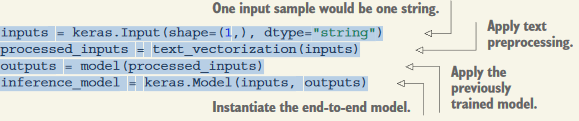

The resulting model can process batches of raw strings:\
import tensorflow as tf\
raw_text_data = tf.convert_to_tensor([
["That was an excellent movie, I loved it."],
])\
predictions = inference_model(raw_text_data)\
print(f"{float(predictions[0] * 100):.2f} percent positive")

### Processing words as a sequence: The sequence model approach
These past few examples clearly show that word order matters: manual engineering of order-based features, such as bigrams, yields a nice accuracy boost. Now remember: the history of deep learning is that of a move away from manual feature engineering, toward letting models learn their own features, we exposed the model to raw word sequences and let it figure out such features on its own? This is what sequence models are about.\
To implement a sequence model, you start by representing your input samples as sequences of integer indices. Then, you'd map each integer to a vector to obtain vector sequences. Finally, you feed these sequences of vectors into a stack of layers that could cross-correlate features from adjacent vectors, such as a 1D convnet, a RNN, or Transformer.\
Nowadays, sequence modelling is almost universally done with Transformers. Oddly, one-dimensional convnets were never very popular in NLP, even though, a residual stack of depth-wise-separable 1D convolutions can often achieve comparable performance to a bidirectional LSTM, at a greatly reduced computational cost.
### First Practical example

In [25]:
from tensorflow.keras import layers

max_length=600
max_tokens=20000
text_vectorization=layers.TextVectorization(max_tokens=max_tokens,output_mode='int',output_sequence_length=max_length)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(lambda x,y: (text_vectorization(x),y), num_parallel_calls=4)
int_val_ds = val_ds.map(lambda x,y: (text_vectorization(x),y), num_parallel_calls=4)
int_test_ds = test_ds.map(lambda x,y: (text_vectorization(x),y), num_parallel_calls=4)

next, let's make the model. The simplest way to convert our integer sequences to vector sequences is to one-hot encode the integers. On top of these one-hot vectors, we'll add a simple bidirectional LSTM.

In [26]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype='int64')
embedded = tf.one_hot(inputs,depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs=layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs,outputs)
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 20000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               5128448   
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,128,513
Trainable params: 5,128,513
Non-trainable params: 0
_________________________________________________

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint('one_hot_bidir_lstm.keras', save_best_only=True)]
model.fit(int_train_ds, validation_data=int_val_ds,epochs=10,callbacks=callbacks)
model = keras.model.load_model('one_hot_bidir_lstm.keras')
print(f'Test acc: {model.evaluate(int_test_ds)[1]:.3f}')

Epoch 1/10
625/625 [==============================] - 159s 247ms/step - loss: 0.5688 - accuracy: 0.7064 - val_loss: 0.3782 - val_accuracy: 0.8576
Epoch 2/10
356/625 [================>.............] - ETA: 57s - loss: 0.3962 - accuracy: 0.8503

A first observation: this model trains very slowly, especially compared to the lightweight model of the previous section. This is because our inputs are quite large: each input sample is encoded as a matrix of size (600,20000) (600 words per sample, 20,000 possible words). That's 12,000,000 floats for a single movie review. Our bidirectional LSTM has a lot of work to do. Second, the model only gets to 87% test accuracy-it doesn't perform nearly as well as out binary unigram model.
Clearly, using one-hot encoding turn words into vectors, which was the simplest thing we could do, wasn't a great idea. There's a better way: word embeddings.

### Understanding Word Embeddings
When you encode something via one-hot you are making a feature enginnering decision. You are injecting into your model a fundamental assumption about the structure of your feature space. That assumption is taht the different tokens you are encoding are all independent from each other: one-hot vectors are all orthogonal to one another.\
Words form a structured space: they share information with each other. To get a bit more abstract, the geometric relationship between two word vectors should reflect the semantic relationship between these words. For instance, in a reasonable word vector space, you would expect synonyms to be embedded into similar word vectors, and in general, you expect geometric distance between any two word vectors to relate to the semantic distance between the associated words. Words that mean different things should lie far away from each otherm whereas related words should be closer.\
Word embeddings are vector representations of words that achieve exactly this: they map human language into a structured geometric space.\
Wheras the vectors obtained through one-hot encoding are binary, sparse and very high-dimensional, word embeddings are low-dimensional floating-point vectors.\
It’s common to see word embeddings that are 256-dimensional 512-dimensional, or 1,024-dimensional 330 CHAPTER 11 Deep learning for text
when dealing with very large vocabularies. On the other hand, one-hot encoding words
generally leads to vectors that are 20,000-dimensional or greater (capturing a vocabu-
lary of 20,000 tokens, in this case). So, word embeddings pack more information into
far fewer dimensions.

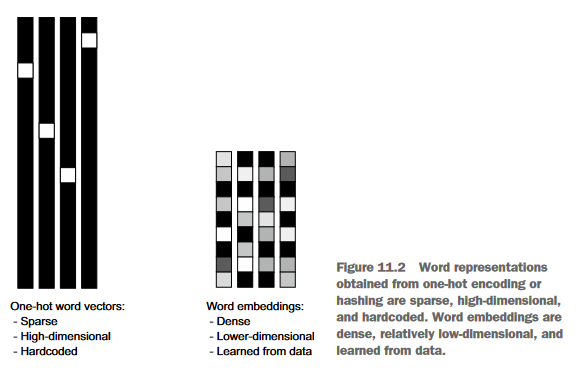

Besides being dense represetnations,word embeddings are also structured representations, and their structure is learned from data. similar words get embedded in close locations, and further, specific directions in the embedding space are meaningful.\
In real-world word-embedding spaces, common examples of meaningful transformations are "gender" vectors and "plural" vectors. For instance, by adding a "female" vector to the vector "king" we obtain the vetor "queen".\
Let's look at how to use such an embedding space in practice. There are two ways to obtain word embeddings:
* Learn word embeddings jointly with the main task you care about (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network.
* Load into your model word embeddings that were precomputed using a different machine learning task than the one you are trying to solve. These are called pretrained word embeddings.

#### Learning word embeddings with Embedding layer
Is there some ideal word-embedding space that would perfectly map human language and could be used for any natural language processing task? Possibly, but we have yet to compute anything of the sort. Also, there is no such a thing as human language. What makes a good word-embedding space depends heavily on your task.\
It's thus reasonable to learn a new embedding space with every new task. Fortunately, backpropagation makes this easy, and Keras makes it even easier. It's about learning the weights of a layer: The Embedding layer.

In [ ]:
embedding_layer=layers.Embedding(input_dim=max_tokens, output_dim=256)

The Embedding layer is best understood as a dictionary that maps integer indices to dense vectors. It takes integers as input, looks up these integers in an internal dictionary and returns the associated vectors. It's effectively a dictionary lookup.\
Word index -> Embedding Layer -> Corresponding word vector\
The Embedding layer takes as input a rank-2 tensor of integers, of shape (batch_size,sequence_length), where each entry is a sequence of integers. The layer then returns a 3D floating-point tensor of shape (batch_size, sequence_length, embedding_dimensionality).\
When you instantiate Embedding layer, its weights are initially random, just as with any other layer. During training, these word vectors are gradually adjusted via backpropagation, structuring the space into something the downstream model can exploit. Once fully trained, the embedding space will show a lot of structure- a kind of structure specialized for the specific problem for hwich you are training your model.

In [ ]:
#Model using Embedding layer trained from scratch

inputs = keras.Input(shape=(None,), dtype='int64')
embedded = layers.Embedding(input_dim=max_tokens,output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs,outputs)
model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
callbacks=[keras.callbacks.ModelCheckpoint('embeddings_bidir_gru.keras'),save_best_only=True]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10,callbacks=callbacks)
model = keras.models.load_model('embeddings_bidir_gru.keras')
print(f"Train acc: {model.evaluate(int_test_ds)[1]:.3f}")

It trains much faster than the one-hot model, and its test accuracy is comparable. However, we're still way off form the results of our basic bigram model. Part of the reason is simply that the model is looking at slightly less data: the bigram model processed full reviews, while our sequence model truncates sequences after 600 words.

#### Understanding Padding and Masking

